# Task
From an array of size $2^n$ where $n \in [2,4]$ has integers ranging from the range of (0,32) has one number repeated throughout the array. The objective of this project is to identify the indices with the highest possible probability.
For this we check the following examples.

### Example 1

if n = 2 
we have a array of  size 4 with the following numbers [1,6,2,6]  in this case the reapeat number is 6, which is located in positions 1 and 3  or it could be 3 and 1 of the array.

### Example 2

if n = 4

we have a array of  size 4 with the following numbers [10,12,8,4,11,25,31,13,2,1,9,30,13,5,7,14]  in this case the reapeat number is 55, which is localed in position 2 and 15 of the array.

## Challenge

Generate a quantum algorithm that returns the repeated number indices of the input array and consider an integer  array of $2^n$ where $n \in [2,4]$ .

### Part 1

Obtain by your proposed quantum circuit the indices of the repeated values of the following array 

#### [13,13,1,31], where n = 2

### Part 2

Use the quantum circuit diagram from part 1 to solve part 2 but considering the following values.

#### [1,2,3,6,29,30,3,4], where n = 3


### Part 3

Use the quantum circuit diagram from part 2 to solve part 2 but considering the following values.

#### [10,12,8,4,11,25,31,13,2,1,9,30,13,5,7,14],  where n = 4


# Scheme of the proposal Solution




## Rerefences
[1] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), arXiv:quant-ph/9605043

[2] https://www.ibm.com/blogs/research/2020/12/quantum-challenge-fall-results/

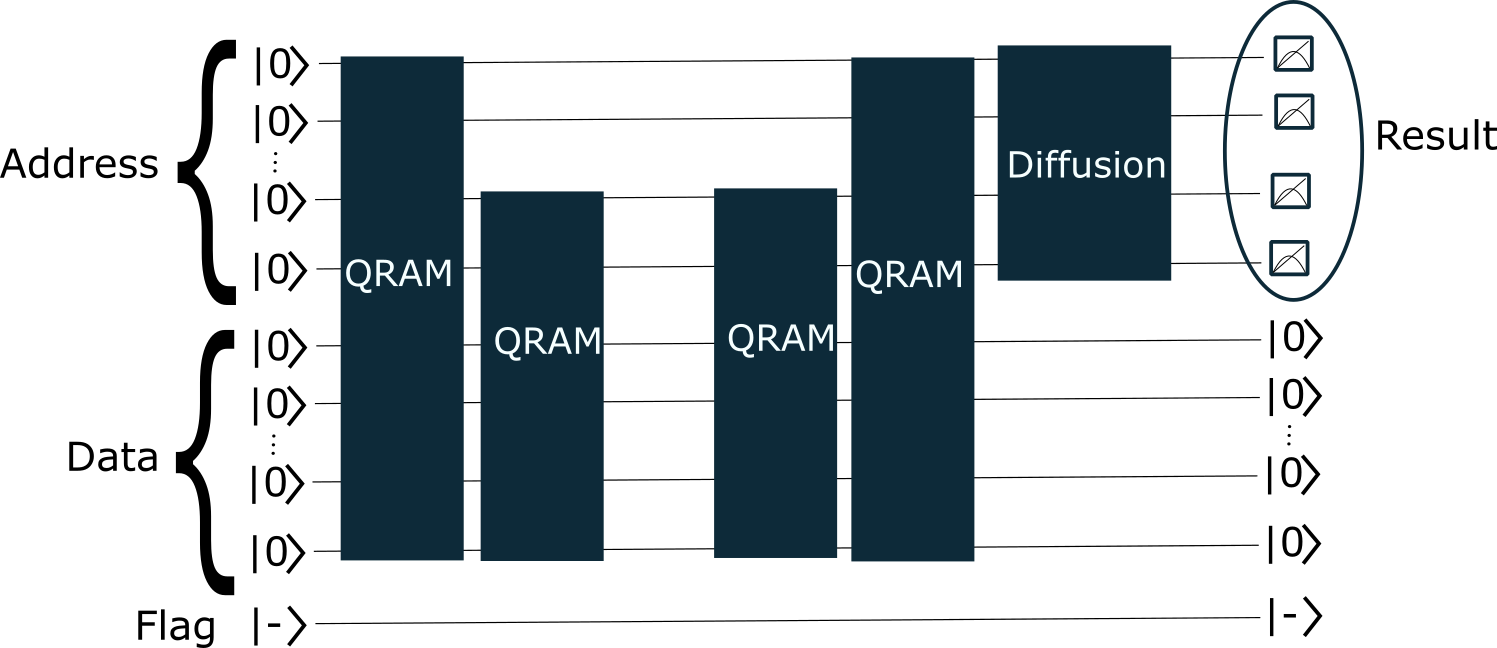

In [ ]:
from IPython.display import Image
Image('design.png')

# Design of the generic solution

The process of solving this problem was performed using the qiskit framework.

In [ ]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister,execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
import operator

## Init variables

Design of a function that initial the qubits like show in the scheme

In [ ]:
def init_qubits(qc,q_oracle,address_1,address_2):
    qc.x(q_oracle)
    qc.h(q_oracle)
    qc.h(address_1)
    qc.h(address_2)
    qc.barrier()
    qc.draw()

Auxliliar function to pass the integer value into a list of the position  that is neccesary for the QRAM structure.

In [ ]:
def indexPosicion(value):
    list_bin = []
    temp = bin(value)[2:]
    temp = temp[::-1]
    for i in range(len(temp)):
        if temp[i] == '1':
            list_bin.append(i)
    return list_bin

Generate a QRAM that it couldbe work in any size of  n qubits.

In [ ]:
def qram(qc,address,ancilla,data,len_arr):
    for i in range(len_arr):
        x_gates_array = indexPosicion(i)
        if x_gates_array:
            qc.x(address[x_gates_array])
            qc.mct(address,ancilla)
            qc.cx(ancilla, data[indexPosicion(arr[i])])
            qc.mct(address,ancilla)
            qc.x(address[x_gates_array])
        else:
            qc.mct(address,ancilla)
            qc.cx(ancilla, data[indexPosicion(arr[i])])
            qc.mct(address,ancilla)
        qc.barrier()

Difusser function obtain for qiskit textbook using in the next link https://qiskit.org/textbook/ch-algorithms/grover.html

In [ ]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

Design of the oracle part to identify the repeat number for the array

In [ ]:
def oracle_function(qc,q_oracle,address,address_1,address_2,data,ancilla_1,ancilla_2,ancilla_3,n):
    qc.x(data)
    qc.mct(data,q_oracle)
    qc.x(data)
    qc.barrier()

    for i in range(n):
        x_gates_array = indexPosicion(i)
        if x_gates_array:
            for j in x_gates_array:
                qc.x([address_1[j]])
                qc.x([address_2[j]])
            qc.mct(address,ancilla_3)
            for j in x_gates_array:
                qc.x([address_1[j]])
                qc.x([address_2[j]])
        else:
            qc.mct(address,ancilla_3)
        qc.barrier()
    qc.x(ancilla_3)
    qc.cx(ancilla_3,q_oracle)
    qc.x(ancilla_3)
    qc.barrier()


Join all the fuction in a quantum circuit.

In [ ]:
def grover_algorithm(arr):
    n = len(arr)
    len_data = int(np.log2(n))
    m = 5
    flag = 1
    address_1 = QuantumRegister(len_data)
    ancilla_1 = QuantumRegister(flag)
    address_2 = QuantumRegister(len_data)
    ancilla_2 = QuantumRegister(flag)
    ancilla_3 = QuantumRegister(flag)

    data = QuantumRegister(m)
    q_oracle = QuantumRegister(flag)
    cr = ClassicalRegister(len_data*2)
    qc = QuantumCircuit(address_1,address_2,ancilla_1,ancilla_2,data,ancilla_3,q_oracle,cr)

    address = []
    for i in range(len_data):
        address.append(address_1[i])
    for i in range(len_data):
        address.append(address_2[i])


    init_qubits(qc,q_oracle,address_1,address_2)
    qram(qc,address_1,ancilla_1,data,n)
    qram(qc,address_2,ancilla_2,data,n)

    oracle_function(qc,q_oracle,address,address_1,address_2,data,ancilla_1,ancilla_2,ancilla_3,n)

    qram(qc,address_1,ancilla_1,data,n)
    qram(qc,address_2,ancilla_2,data,n)
    qc.barrier()
    qc.append(diffuser(len_data*2),address)
    qc.barrier()
    qc.x(address)
    qc.barrier()
    qc.measure(address,cr)
    return qc

## Check the part 1

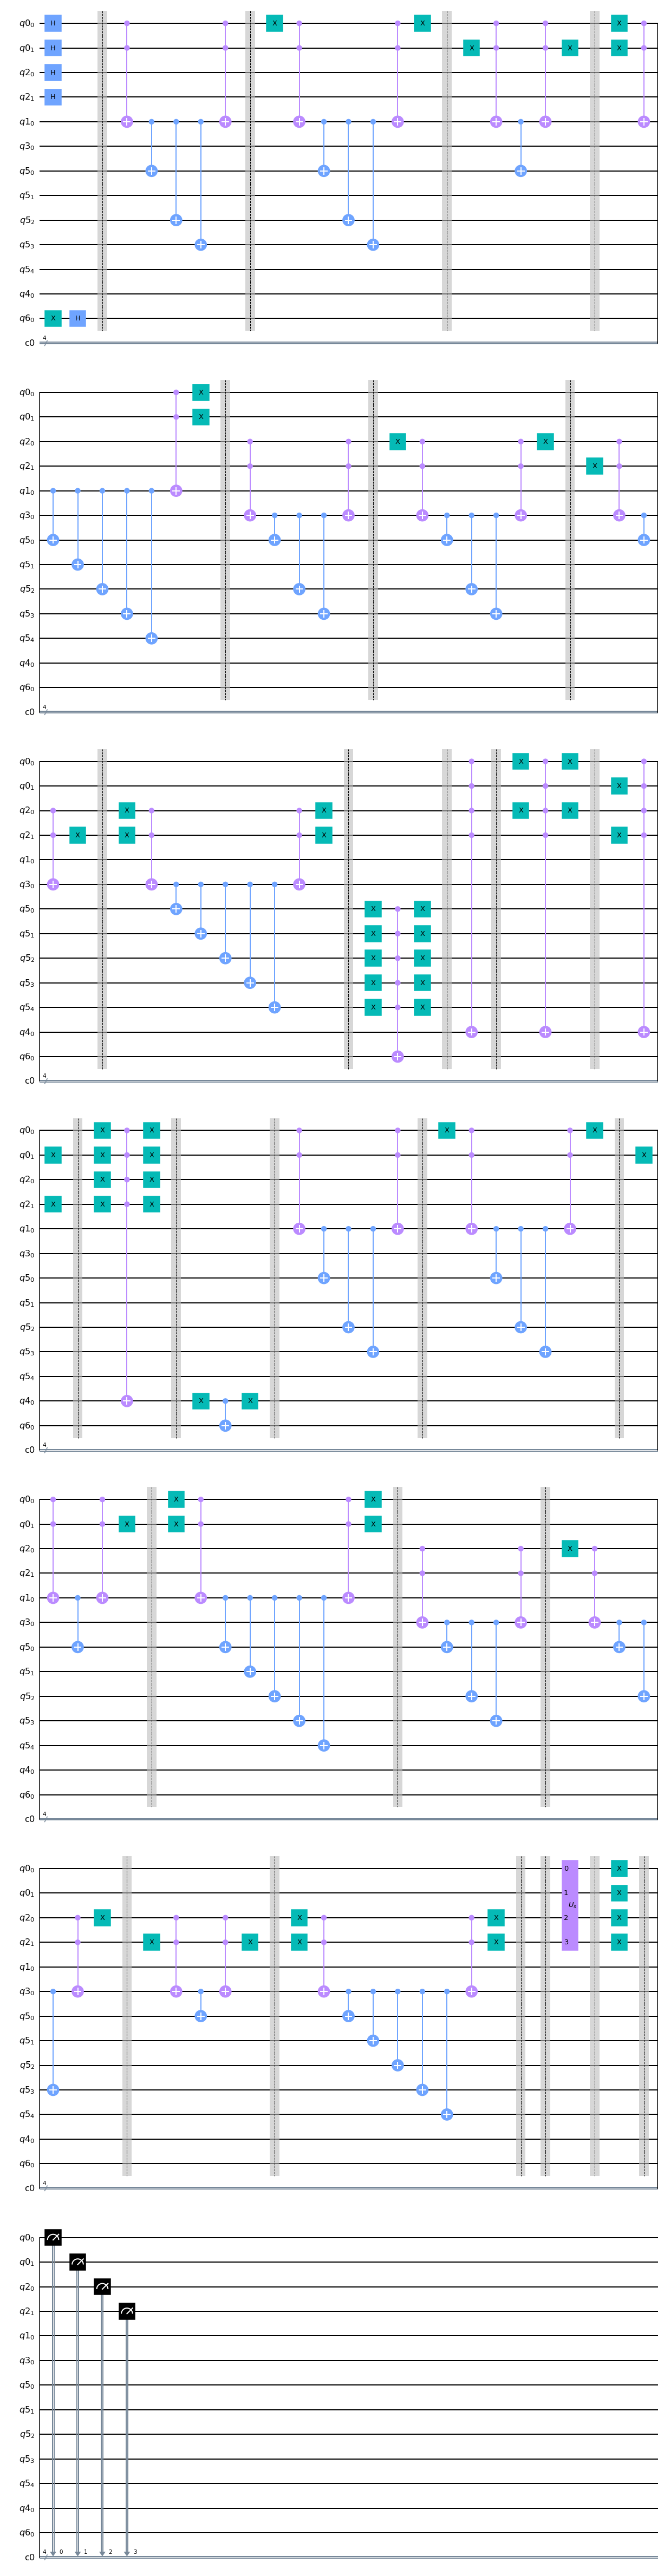

In [ ]:
arr =[13,13,1,31] #00-11
qc = grover_algorithm(arr)
qc.draw()

### Obtain the solution and its histogram

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
output = max(counts.items(), key=operator.itemgetter(1))[0]

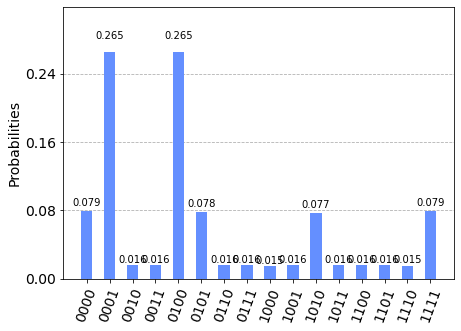

In [ ]:
plot_histogram(job.result().get_counts(qc))

In [ ]:
## valid answer
print(output)
sol_1 = int(output[:2], 2)
sol_2 = int(output[2:], 2)

if sol_1 == 0 and sol_2 == 1:
        print("You are correct :) ! The index of the repeat number are ",sol_1,sol_2 )
elif sol_1 ==1 and sol_2 == 0:
        print("You are correct :) ! The index of the repeat number are ",sol_1,sol_2 )
else:
        print("Wrong anser, please check your code :(")

0001
You are correct :) ! The index of the repeat number are  0 1


## Check the part 2

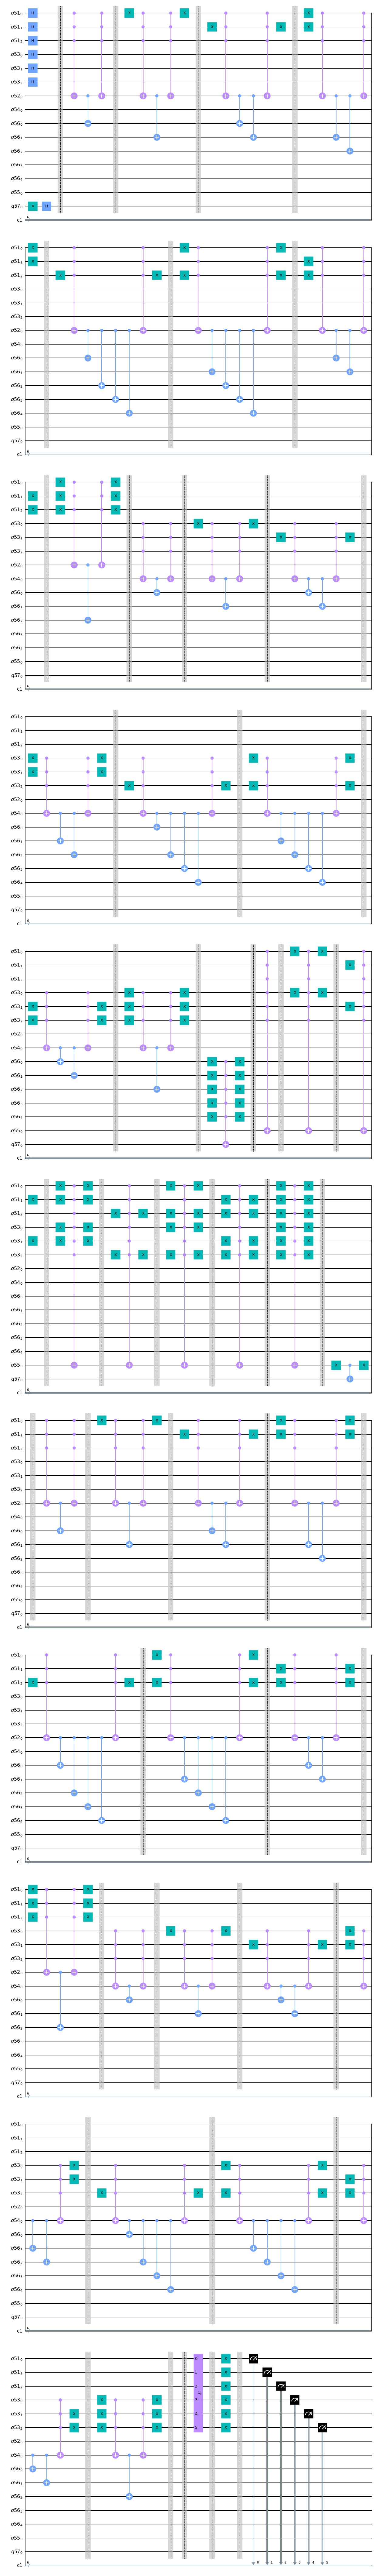

In [ ]:
arr =[1,2,3,6,29,30,3,4] #010-110
qc = grover_algorithm(arr)
qc.draw()

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
output_2 = max(counts.items(), key=operator.itemgetter(1))[0]

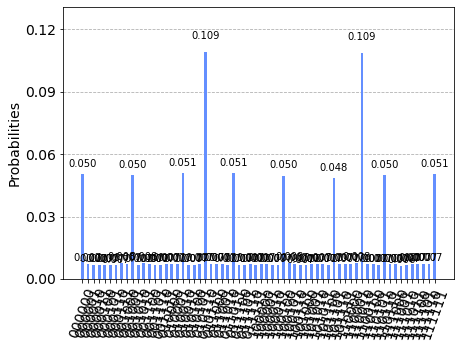

In [ ]:
plot_histogram(job.result().get_counts(qc))

In [ ]:
## valid answer
print(output_2)
sol_3 = int(output_2[:3], 2)
sol_4 = int(output_2[3:], 2)

if sol_3 == 2 and sol_4 == 6:
        print("You are correct :) ! The index of the repeat number are ",sol_3,sol_4)
elif sol_3 ==6 and sol_4 == 2:
        print("You are correct :) ! The index of the repeat number are ",sol_3,sol_4 )
else:
        print("Wrong anser, please check your code :(")

010110
You are correct :) ! The index of the repeat number are  2 6


## Check the part 3

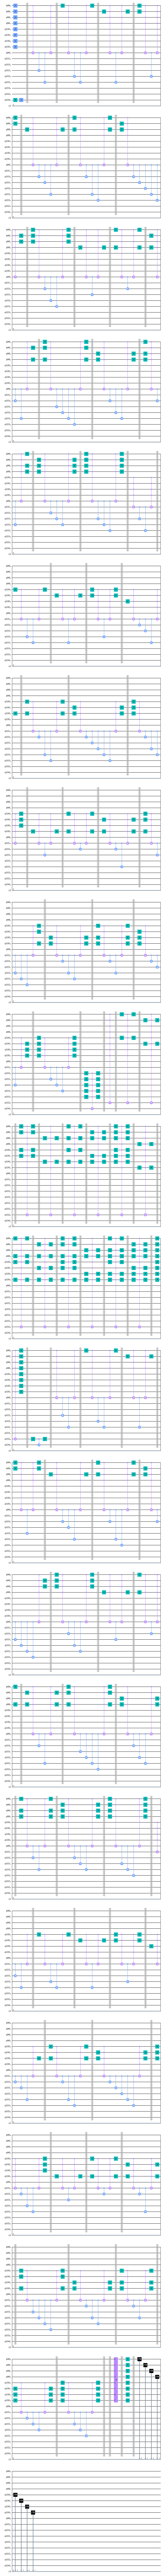

In [ ]:
arr =[10,12,8,4,11,25,31,13,2,1,9,30,13,5,7,14] #0111-1100
qc = grover_algorithm(arr)
qc.draw()

In [ ]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
output_3 = max(counts.items(), key=operator.itemgetter(1))[0]

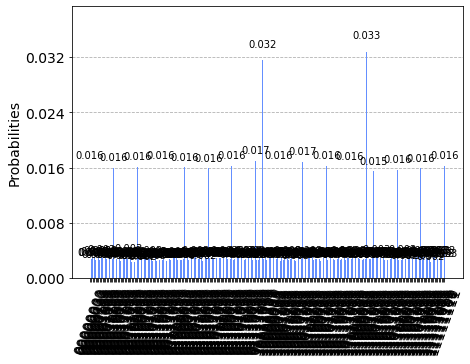

In [ ]:
plot_histogram(job.result().get_counts(qc))

In [ ]:
## valid answer
print(output_3)
sol_5 = int(output_3[:4], 2)
sol_6 = int(output_3[4:], 2)

if sol_5 == 12 and sol_6 == 7:
        print("You are correct :) ! The index of the repeat number are ",sol_5,sol_6 )
elif sol_5 == 7 and sol_6 == 12:
        print("You are correct :) ! The index of the repeat number are ",sol_5,sol_6 )
else:
        print("Wrong anser, please check your code :(")

11000111
You are correct :) ! The index of the repeat number are  12 7
